# Image classification with convolutional neural networks

In this script we create, train and evaluate an image classifier based on convolutional neural networks (CNNs).

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import copy

# Define the data repository
data_dir = 'data/'

In [2]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

## Dataset

In this lab we work with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset: it's similar to MNIST, but these are images of clothes from Zalando instead of digits.

<center><a href="https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5">
    <img src="https://miro.medium.com/max/1400/1*jXssb_WjoYZgepOCfdQfJA.png" width="400"></a></center>

Like MNIST, each image comes with a label between 0 and 9 (10 classes). The mapping between integer labels and actual classes (0 = t-shirt, 1 = trousers, etc.) can be found [here](https://github.com/zalandoresearch/fashion-mnist#labels).

In [3]:
# Just like MNIST, you can download the data by setting'download=True' directly from pytorch
train_data = datasets.FashionMNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

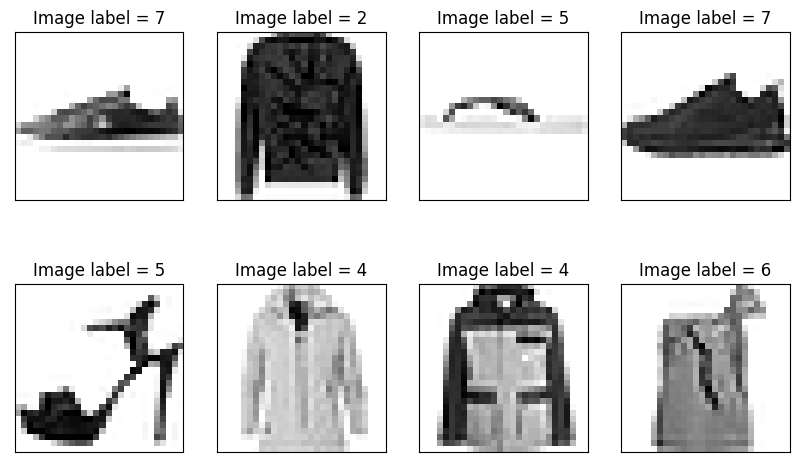

In [4]:
# Get a batch of images from the train dataloader and print it
image_batch_example, labels_batch_example = next(iter(train_dataloader))

plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze().detach(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## CNN classifier

A CNN classifier usually consists of:
- one or several convolutional layers/modules, which produce intermediate latent representations called ***feature maps***
- one or several linear layers, which perform classification from the feature maps

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png"></a></center>

### Example

In [5]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [7]:
# TO DO: create the second CNN layer, with the same structure as the first one
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels (and same kernel_size/padding/)
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.
cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([8, 32, 7, 7])


In [10]:
# Now, we define a linear layer to perform classification (as in Lab 3)

# First, we need to flatten out2, since linear layers in pytorch process vectors (or more precisely batches of vectors)
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate shape (size of the vectorized input, 10 output classes)
# Apply this layer to the vectorized image
fc = nn.Linear(1568,10)
out3 = fc(out2.view(out2.shape[0], -1))
print(out3.shape)

torch.Size([8, 1568])
torch.Size([8, 10])


### General module

Now, let's create a general CNN classification network, train and test it.

In [45]:
# TO DO: Define the CNN classifier module ('__init__' and 'forward' methods).
# It's architecture is the same as in the example above.

class CNNClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(1568, num_classes)
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.fc(x.reshape(x.shape[0], -1))
        #print(out.shape)
        return out 

In [56]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
model = CNNClassif(num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization (ensure reproducibility: everybody should have the same results)
torch.manual_seed(0)
model.apply(init_weights)

Total number of parameters:  28938


CNNClassif(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

## Training and evaluation

In [57]:
# TO DO: write the training function (no validation).
# It's almost the same as in lab3, except we don't need to vectorize the images:
# (indeed, MLPs take a vector as input, while CNNs directly process the image).
def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            y_pred = model_tr(images)
            l = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

Epoch [1/20], Loss: 110.9706
Epoch [2/20], Loss: 91.6030
Epoch [3/20], Loss: 71.7295
Epoch [4/20], Loss: 62.3299
Epoch [5/20], Loss: 55.8445
Epoch [6/20], Loss: 50.2099
Epoch [7/20], Loss: 46.6967
Epoch [8/20], Loss: 44.7229
Epoch [9/20], Loss: 41.4609
Epoch [10/20], Loss: 38.9632
Epoch [11/20], Loss: 36.9951
Epoch [12/20], Loss: 35.2485
Epoch [13/20], Loss: 33.5020
Epoch [14/20], Loss: 31.5776
Epoch [15/20], Loss: 32.4419
Epoch [16/20], Loss: 31.1982
Epoch [17/20], Loss: 29.0591
Epoch [18/20], Loss: 28.5592
Epoch [19/20], Loss: 29.1934
Epoch [20/20], Loss: 26.6694


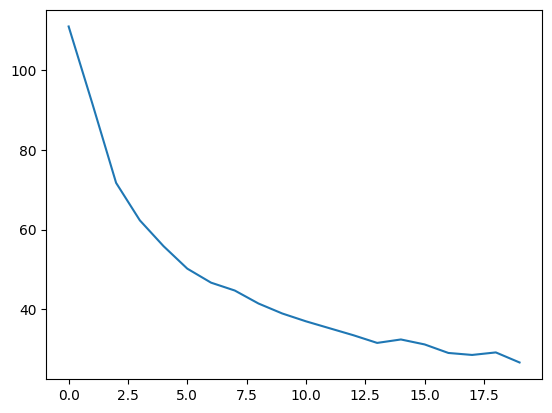

In [58]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

# Training
model, loss_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total)
plt.show()

In [50]:
# Eval function

def eval_cnn_classifier(model, eval_dataloader):

    # Set the model in evaluation mode
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            # print(images.shape)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [51]:
# TO DO: Evaluate the model on the test set (instantiate the model, load the trained parameters and use the
# evaluation function). Display the accuracy on the test set.
acc1 = eval_cnn_classifier(model, test_dataloader)
acc1

68.0

<span style="color:red">**Q3**</span> What is the test accuracy?

## Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use **batch normalization**, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Batch norm is easy to write in Pytorch (see the [doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)).

**Note**: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [54]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each CNN layer, between RELU and Maxpooling.

class CNNClassif_bnorm(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=10):
        super(CNNClassif_bnorm, self).__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels2,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        self.fc = nn.Linear(1568, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        out = self.fc(x.reshape(x.shape[0], -1))
        return out

Epoch [1/20], Loss: 115.1074
Epoch [2/20], Loss: 48.5088
Epoch [3/20], Loss: 30.8023
Epoch [4/20], Loss: 16.4470
Epoch [5/20], Loss: 10.2784
Epoch [6/20], Loss: 7.0882
Epoch [7/20], Loss: 6.8662
Epoch [8/20], Loss: 2.0225
Epoch [9/20], Loss: 1.2314
Epoch [10/20], Loss: 0.9523
Epoch [11/20], Loss: 0.6998
Epoch [12/20], Loss: 0.6455
Epoch [13/20], Loss: 0.5630
Epoch [14/20], Loss: 0.4653
Epoch [15/20], Loss: 0.4325
Epoch [16/20], Loss: 0.3959
Epoch [17/20], Loss: 0.3741
Epoch [18/20], Loss: 0.3375
Epoch [19/20], Loss: 0.3238
Epoch [20/20], Loss: 0.2841


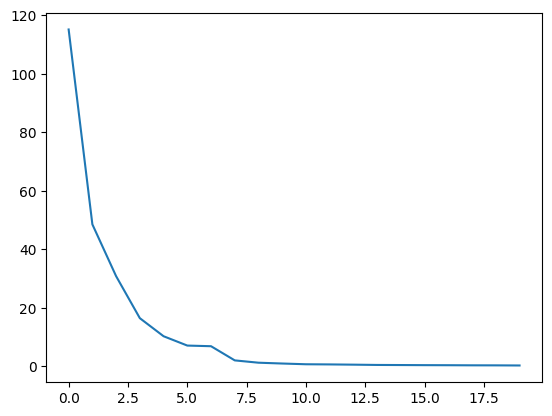

Accuracy of the network on the test images:  72.0 %


In [55]:
# TO DO:
# - instantiate the model and initialize it for reproducibility
# - train it, save the parameters, and plot the training loss
# - evaluate it and print the test accuracy

model_bn = CNNClassif_bnorm(num_channels1, num_channels2, num_classes)
torch.manual_seed(0)
model_bn.apply(init_weights)

model_bn, loss_total = training_cnn_classifier(model_bn, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)
torch.save(model_bn.state_dict(), 'model_cnn_classif_bn.pt')
plt.plot(loss_total)
plt.show()

accuracy_bn = eval_cnn_classifier(model_bn, test_dataloader)
print('Accuracy of the network on the test images: ', accuracy_bn, '%')

<span style="color:red">**Q4**</span> What is the test accuracy? Is it better than without batch norm?